In [2]:
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import keras
import sent2vec
import seq2seq
from seq2seq.models import AttentionSeq2Seq
from seq2seq.models import Seq2Seq
from keras.utils import multi_gpu_model
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import pickle
import tqdm
from tqdm import tqdm


import numpy as np
from random import shuffle
from math import log, floor
import pandas as pd
import tensorflow as tf
import tensorboard as tb
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.utils import *
from keras.layers.advanced_activations import *
from keras import *
from keras.engine.topology import *
from keras.optimizers import *
import gensim
from gensim.models.word2vec import *
from keras.preprocessing.text import *
from keras.preprocessing.sequence import *
from keras.utils import *
from sklearn.model_selection import *
import random
from random import shuffle
import re
# from collections import Counter
from keras.utils.generic_utils import *
from keras import regularizers
import string
import unicodedata as udata
import pickle
from keras.applications import *
from keras.preprocessing.image import *
import pause, datetime

Using TensorFlow backend.


In [3]:
df_enc = pickle.load(open('output/api_enc2.pkl','rb'))
df_enc

,<BOS>,<EOS>,<MOS>,<PAD>,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,CreateThread,DeleteFile,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
model = sent2vec.Sent2vecModel()
model.load_model('model/sent2vec_asp1_profile_REP.bin')

In [5]:
%run MotifAnalysis/Hooklog3.ipynb
Hooklog = Hooklog3

## get each hooklog's trainX

## combine all train data to 3D array
* trainX: (N,upper_bound,api_dim+param_dim)
* trainY2: (N,upper_bound_rep,api_dim+param_dim)

In [20]:
root_dir = './data/tree-rep-logs-profile/'
out_dir = './data/tree-rep-logs-profile/'
lower_bound = 24 #Q1
upper_bound = 160 #Q3
window_size = 8
upper_bound_rep = 532 #debug max_size

max_size = 0
pad_npy = df_enc['<PAD>'].values
pad_npy = np.expand_dims(pad_npy,axis=0)
pad_npy_param = model.embed_sentence(' <PAD>'*window_size)
dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
# in_parseFirstPar=False
trainX=[]
trainY=[]
fam_dir = next(os.walk(root_dir))[1]
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        out_directory = out_dir + fam + '/' + tree + '/'
        if not os.path.exists(out_directory):
            os.makedirs(out_directory)
        hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
        hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
        hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list))
        for hkl in hl_list:
            param = []
            with open(hkl , encoding='ISO 8859-1') as f:
                profile = f.read().splitlines()
            if (len(profile)<lower_bound or len(profile)>upper_bound):
                continue
            else:
                for line in profile:
                    temp = re.sub(dil," ",line)
                    temp = temp.replace('PR','')
                    temp = temp.replace('Ret','')
                    temp = temp.replace('SUBK','')
                    temp = temp.split(" ")
                    temp = list(filter(None, temp))
                    temp = ' '.join(temp)
                    temp = model.embed_sentence(temp) #(132,)
                    temp = np.squeeze(temp)
                    param.append(temp)
                param = np.array(param) #(length,132)
                profile = [i.split('#PR')[0] for i in profile]
                profile = np.array([df_enc[i] for i in profile]) #(legth,32)
#                 profile = np.concatenate((profile,param),axis=1)
                size = len(profile)
                if size<upper_bound:
                    for _ in range(upper_bound - size):
                        profile = np.append(profile,pad_npy,axis=0) #(upper,32)
                        param = np.append(param,pad_npy_param,axis=0)
                profile = np.concatenate((profile,param),axis=1)
                trainX.append(profile)
                
                #trainY rep
                rep_api = pickle.load(open(in_directory+'api_name.pickle','rb')) #(length,32)
                rep_param = pickle.load(open(in_directory+'parameter_rep.pickle','rb'))
                
                param=[]
                for line in rep_param:
                    temp = re.sub(dil," ",line)
                    temp = temp.replace('PR','')
                    temp = temp.replace('Ret','')
                    temp = temp.replace('SUBK','')
                    temp = temp.split(" ")
                    temp = list(filter(None, temp))
                    temp = ' '.join(temp)
                    temp = model.embed_sentence(temp) #(132,)
                    temp = np.squeeze(temp)
                    param.append(temp)
                param = np.array(param)
                size_ = len(rep_api)
                if size_ > upper_bound:
                    print(in_directory,size_)
                if size_ > max_size: #test
                    max_size = size_
#                     continue #debug
#                 break #debug
                if size_ < upper_bound_rep:
                    for _ in range(upper_bound_rep - size_):
                        rep_api = np.append(rep_api,pad_npy,axis=0)
                        param = np.append(param,pad_npy_param,axis=0)
#                 print(rep_api.shape , param.shape)
                rep_api = np.concatenate((rep_api,param),axis=1)
                trainY.append(rep_api)
trainX = np.array(trainX)
trainY2 = np.array(trainY)
print(trainX.shape, trainY2.shape)
#             break #debug




  1%|▏         | 1/80 [00:00<00:44,  1.76it/s]

./data/tree-rep-logs-profile/symmi_0.8/G301/ 164
./data/tree-rep-logs-profile/symmi_0.8/G301/ 164
./data/tree-rep-logs-profile/symmi_0.8/G301/ 164


  4%|▍         | 3/80 [00:03<01:40,  1.31s/it]

./data/tree-rep-logs-profile/elkern_0.8/G203/ 172
./data/tree-rep-logs-profile/elkern_0.8/G203/ 172
./data/tree-rep-logs-profile/elkern_0.8/G203/ 172
./data/tree-rep-logs-profile/elkern_0.8/G193/ 172
./data/tree-rep-logs-profile/elkern_0.8/G193/ 172
./data/tree-rep-logs-profile/elkern_0.8/G193/ 172
./data/tree-rep-logs-profile/elkern_0.8/G188/ 172
./data/tree-rep-logs-profile/elkern_0.8/G188/ 172
./data/tree-rep-logs-profile/elkern_0.8/G188/ 172
./data/tree-rep-logs-profile/elkern_0.8/G147/ 172
./data/tree-rep-logs-profile/elkern_0.8/G147/ 172
./data/tree-rep-logs-profile/elkern_0.8/G220/ 172
./data/tree-rep-logs-profile/elkern_0.8/G220/ 172
./data/tree-rep-logs-profile/elkern_0.8/G220/ 172
./data/tree-rep-logs-profile/elkern_0.8/G220/ 172


  5%|▌         | 4/80 [00:04<01:34,  1.24s/it]

./data/tree-rep-logs-profile/elkern_0.8/G220/ 172


  9%|▉         | 7/80 [00:26<04:41,  3.86s/it]

./data/tree-rep-logs-profile/strictor_0.8/G143/ 532
./data/tree-rep-logs-profile/strictor_0.8/G143/ 532
./data/tree-rep-logs-profile/strictor_0.8/G143/ 532
./data/tree-rep-logs-profile/strictor_0.8/G143/ 532
./data/tree-rep-logs-profile/strictor_0.8/G138/ 532
./data/tree-rep-logs-profile/strictor_0.8/G138/ 532
./data/tree-rep-logs-profile/strictor_0.8/G135/ 532
./data/tree-rep-logs-profile/strictor_0.8/G135/ 532
./data/tree-rep-logs-profile/strictor_0.8/G142/ 532
./data/tree-rep-logs-profile/strictor_0.8/G142/ 532
./data/tree-rep-logs-profile/strictor_0.8/G142/ 532
./data/tree-rep-logs-profile/strictor_0.8/G124/ 532
./data/tree-rep-logs-profile/strictor_0.8/G124/ 532
./data/tree-rep-logs-profile/strictor_0.8/G118/ 532
./data/tree-rep-logs-profile/strictor_0.8/G118/ 532
./data/tree-rep-logs-profile/strictor_0.8/G131/ 532
./data/tree-rep-logs-profile/strictor_0.8/G131/ 532
./data/tree-rep-logs-profile/strictor_0.8/G141/ 532
./data/tree-rep-logs-profile/strictor_0.8/G141/ 532
./data/tree-

 11%|█▏        | 9/80 [00:31<04:11,  3.54s/it]

./data/tree-rep-logs-profile/strictor_0.8/G122/ 532


 12%|█▎        | 10/80 [00:33<03:56,  3.37s/it]

./data/tree-rep-logs-profile/zbot_0.8/G473/ 165
./data/tree-rep-logs-profile/zbot_0.8/G473/ 165
./data/tree-rep-logs-profile/zbot_0.8/G473/ 165


 15%|█▌        | 12/80 [00:42<03:58,  3.51s/it]

./data/tree-rep-logs-profile/installrex_0.8/G70/ 163
./data/tree-rep-logs-profile/installrex_0.8/G70/ 163
./data/tree-rep-logs-profile/installrex_0.8/G70/ 163


 16%|█▋        | 13/80 [00:43<03:44,  3.36s/it]

./data/tree-rep-logs-profile/expiro_0.8/G369/ 163
./data/tree-rep-logs-profile/expiro_0.8/G369/ 163


 25%|██▌       | 20/80 [00:58<02:55,  2.92s/it]

./data/tree-rep-logs-profile/somoto_0.8/G144/ 268
./data/tree-rep-logs-profile/somoto_0.8/G144/ 268
./data/tree-rep-logs-profile/somoto_0.8/G135/ 268
./data/tree-rep-logs-profile/somoto_0.8/G135/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268
./data/tree-rep-logs-profile/somoto_0.8/G158/ 268


 26%|██▋       | 21/80 [01:04<03:00,  3.06s/it]

./data/tree-rep-logs-profile/somoto_0.8/G153/ 268
./data/tree-rep-logs-profile/somoto_0.8/G153/ 268


 31%|███▏      | 25/80 [01:10<02:35,  2.84s/it]

./data/tree-rep-logs-profile/megasearch_0.8/G70/ 162


 35%|███▌      | 28/80 [01:17<02:23,  2.76s/it]

./data/tree-rep-logs-profile/installcore_0.8/G276/ 163
./data/tree-rep-logs-profile/installcore_0.8/G276/ 163
./data/tree-rep-logs-profile/installcore_0.8/G276/ 163
./data/tree-rep-logs-profile/installcore_0.8/G276/ 163
./data/tree-rep-logs-profile/installcore_0.8/G276/ 163


 38%|███▊      | 30/80 [01:20<02:13,  2.67s/it]

./data/tree-rep-logs-profile/mikey_0.8/G94/ 164
./data/tree-rep-logs-profile/mikey_0.8/G94/ 164


 40%|████      | 32/80 [01:22<02:04,  2.59s/it]

./data/tree-rep-logs-profile/shiz_0.8/G58/ 167
./data/tree-rep-logs-profile/shiz_0.8/G58/ 167


 50%|█████     | 40/80 [01:44<01:44,  2.61s/it]

./data/tree-rep-logs-profile/bettersurf_0.8/G38/ 164


 66%|██████▋   | 53/80 [02:49<01:26,  3.19s/it]

./data/tree-rep-logs-profile/delf_0.8/G100/ 206
./data/tree-rep-logs-profile/delf_0.8/G100/ 206
./data/tree-rep-logs-profile/delf_0.8/G99/ 206
./data/tree-rep-logs-profile/delf_0.8/G99/ 206
./data/tree-rep-logs-profile/delf_0.8/G107/ 206


 68%|██████▊   | 54/80 [02:49<01:21,  3.15s/it]

./data/tree-rep-logs-profile/delf_0.8/G107/ 206
./data/tree-rep-logs-profile/delf_0.8/G107/ 206


 69%|██████▉   | 55/80 [02:50<01:17,  3.10s/it]

./data/tree-rep-logs-profile/aira_0.8/G47/ 164
./data/tree-rep-logs-profile/aira_0.8/G47/ 164


 70%|███████   | 56/80 [02:51<01:13,  3.06s/it]

./data/tree-rep-logs-profile/vobfus_0.8/G226/ 167
./data/tree-rep-logs-profile/vobfus_0.8/G226/ 167


 78%|███████▊  | 62/80 [02:56<00:51,  2.85s/it]

./data/tree-rep-logs-profile/loadmoney_0.8/G366/ 164
./data/tree-rep-logs-profile/loadmoney_0.8/G366/ 164
./data/tree-rep-logs-profile/loadmoney_0.8/G366/ 164
./data/tree-rep-logs-profile/loadmoney_0.8/G310/ 162
./data/tree-rep-logs-profile/loadmoney_0.8/G310/ 162


 89%|████████▉ | 71/80 [03:18<00:25,  2.79s/it]

./data/tree-rep-logs-profile/viking_0.8/G40/ 163
./data/tree-rep-logs-profile/viking_0.8/G40/ 163


 94%|█████████▍| 75/80 [03:34<00:14,  2.87s/it]

./data/tree-rep-logs-profile/installerex_0.8/G96/ 165
./data/tree-rep-logs-profile/installerex_0.8/G96/ 165


 95%|█████████▌| 76/80 [03:36<00:11,  2.84s/it]

./data/tree-rep-logs-profile/zusy_0.8/G237/ 165
./data/tree-rep-logs-profile/zusy_0.8/G237/ 165


100%|██████████| 80/80 [03:43<00:00,  2.80s/it]


(4132, 160, 128) (4132, 532, 128)


In [21]:
max_size

532

In [166]:
#移除錯誤的pickle檔案
fam_dir = next(os.walk(root_dir))[1]
for fam in fam_dir:
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        if not os.path.exists(out_directory):
            os.makedirs(out_directory)
        hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
        hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
        hl_list = list(filter(lambda f: f.endswith(".pickle"), hl_list)) #remove pickle
        for hkl in hl_list:
            if len(pickle.load(open(hkl,'rb'))) > 86:
                print(hkl , len(pickle.load(open(hkl,'rb'))))
#             os.remove(hkl)

./data/tree-rep-logs-profile/crytex_0.8/G52/api_name.pickle 331
./data/tree-rep-logs-profile/crytex_0.8/G52/parameter_rep.pickle 331
./data/tree-rep-logs-profile/symmi_0.8/G278/api_name.pickle 245
./data/tree-rep-logs-profile/symmi_0.8/G278/parameter_rep.pickle 245
./data/tree-rep-logs-profile/symmi_0.8/G248/api_name.pickle 113
./data/tree-rep-logs-profile/symmi_0.8/G248/parameter_rep.pickle 113
./data/tree-rep-logs-profile/symmi_0.8/G263/api_name.pickle 535
./data/tree-rep-logs-profile/symmi_0.8/G263/parameter_rep.pickle 535
./data/tree-rep-logs-profile/symmi_0.8/G317/api_name.pickle 489
./data/tree-rep-logs-profile/symmi_0.8/G317/parameter_rep.pickle 489
./data/tree-rep-logs-profile/symmi_0.8/G282/api_name.pickle 656
./data/tree-rep-logs-profile/symmi_0.8/G282/parameter_rep.pickle 656
./data/tree-rep-logs-profile/symmi_0.8/G268/api_name.pickle 269
./data/tree-rep-logs-profile/symmi_0.8/G268/parameter_rep.pickle 269
./data/tree-rep-logs-profile/symmi_0.8/G285/api_name.pickle 132
./dat

./data/tree-rep-logs-profile/fesber_0.8/G135/api_name.pickle 237
./data/tree-rep-logs-profile/fesber_0.8/G135/parameter_rep.pickle 237
./data/tree-rep-logs-profile/fesber_0.8/G122/api_name.pickle 171
./data/tree-rep-logs-profile/fesber_0.8/G122/parameter_rep.pickle 171
./data/tree-rep-logs-profile/downloadguide_0.8/G40/api_name.pickle 786
./data/tree-rep-logs-profile/downloadguide_0.8/G40/parameter_rep.pickle 786
./data/tree-rep-logs-profile/downloadguide_0.8/G39/api_name.pickle 106
./data/tree-rep-logs-profile/downloadguide_0.8/G39/parameter_rep.pickle 106
./data/tree-rep-logs-profile/mira_0.8/G198/api_name.pickle 94
./data/tree-rep-logs-profile/mira_0.8/G198/parameter_rep.pickle 94
./data/tree-rep-logs-profile/mira_0.8/G202/api_name.pickle 94
./data/tree-rep-logs-profile/mira_0.8/G202/parameter_rep.pickle 94
./data/tree-rep-logs-profile/mira_0.8/G226/api_name.pickle 94
./data/tree-rep-logs-profile/mira_0.8/G226/parameter_rep.pickle 94
./data/tree-rep-logs-profile/mira_0.8/G223/api_na

./data/tree-rep-logs-profile/aira_0.8/G47/parameter_rep.pickle 164
./data/tree-rep-logs-profile/aira_0.8/G52/api_name.pickle 89
./data/tree-rep-logs-profile/aira_0.8/G52/parameter_rep.pickle 89
./data/tree-rep-logs-profile/vobfus_0.8/G226/api_name.pickle 167
./data/tree-rep-logs-profile/vobfus_0.8/G226/parameter_rep.pickle 167
./data/tree-rep-logs-profile/vobfus_0.8/G248/api_name.pickle 103
./data/tree-rep-logs-profile/vobfus_0.8/G248/parameter_rep.pickle 103
./data/tree-rep-logs-profile/vobfus_0.8/G217/api_name.pickle 1259
./data/tree-rep-logs-profile/vobfus_0.8/G217/parameter_rep.pickle 1259
./data/tree-rep-logs-profile/vobfus_0.8/G242/api_name.pickle 509
./data/tree-rep-logs-profile/vobfus_0.8/G242/parameter_rep.pickle 509
./data/tree-rep-logs-profile/vobfus_0.8/G232/api_name.pickle 256
./data/tree-rep-logs-profile/vobfus_0.8/G232/parameter_rep.pickle 256
./data/tree-rep-logs-profile/vobfus_0.8/G207/api_name.pickle 109
./data/tree-rep-logs-profile/vobfus_0.8/G207/parameter_rep.pickl

In [23]:
pickle.load(open('./data/tree-rep-logs-profile/strictor_0.8/G125/parameter_rep.pickle','rb'))
with open('./data/tree-rep-logs-profile/strictor_0.8/G125/','rb') as f:
    
# len(pickle.load(open('data/tree-rep-logs-profile/soft_0.8/G33/api_name.pickle','rb')))

# len(pickle.load(open('data/tree-rep-logs-profile/picsys_0.8/G80/api_name.pickle','rb')))
# len(pickle.load(open('data/tree-rep-logs-profile/picsys_0.8/G80/parameter_rep.pickle','rb')))


['<BOS>',
 'LoadLibrary#PR@SYS@wininet@DLL#Ret#P',
 'LoadLibrary#PR@SYS@advapi32@DLL#Ret#P',
 'LoadLibrary#PR@SYS@advapi32@DLL#Ret#P',
 'RegQueryValue#PR@HKLM@sys_curCtlSet_ctl_sessionManager\\*#PR@SUBK@criticalsectiontimeout#PR@0#PR@22f6a4#Ret#0',
 'RegQueryValue#PR@HKLM@soft_ms_ole\\*#PR@SUBK@rwlockresourcetimeout#PR@0#PR@22f6a8#Ret#P',
 'LoadLibrary#PR@ARB@windowsshell@MANIFEST#Ret#N',
 'CreateFile#PR@ARB@MANIFEST#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_DELETE;FILE_SHARE_READ#Ret#P',
 'RegQueryValue#PR@HKCU@desktop\\#PR@SUBK@smoothscroll#PR@0#PR@77462a48#Ret#P',
 'RegQueryValue#PR@HKCU@soft_ms_win_explorer\\advanced#PR@SUBK@enableballoontips#PR@0#PR@77462170#Ret#P',
 'RegEnumValue#PR@HKLM@soft_ms_winNT_languagepack\\*#PR@SUBK@surr#PR@REG_DWORD#PR@2#Ret#0',
 'RegCreateKey#PR@HKCU@hkey_current_user#PR@SOFTWARE\\Microsoft\\Windows\\CurrentVersion\\Internet Settings#Ret#0',
 'LoadLibrary#PR@SYS@shlwapi@DLL#Ret#P',
 'LoadLibrary#PR@SYS@comdlg32@DLL#Ret#P',
 'RegQueryValue#PR@HKLM@

In [87]:
# len(pickle.load(open('data/tree-rep-logs-profile/yantai_0.8/G46/parameter_rep.pickle','rb')))
# len(pickle.load(open('data/tree-rep-logs-profile/yantai_0.8/G46/api_name.pickle','rb')))

# len(pickle.load(open('data/tree-rep-logs-profile/allaple_0.8/G1286/parameter_rep.pickle','rb')))
# len(pickle.load(open('data/tree-rep-logs-profile/allaple_0.8/G1286/api_name.pickle','rb')))


93

In [24]:
pickle.dump(trainX,open('output/trainX_withParam_'+str(trainX.shape[2])+'.pkl','wb'))
pickle.dump(trainY2,open('output/trainY2_withParam_'+str(trainY2.shape[2])+'.pkl','wb'))
trainX.shape  , trainY2.shape

((4132, 160, 128), (4132, 532, 128))

In [40]:
trainX = pickle.load(open('output/trainX_withParam_128.pkl','rb'))
trainY2 = pickle.load(open('output/trainY2_withParam_128.pkl','rb'))
print(trainX.shape,trainY2.shape)

(4132, 160, 128) (4132, 167, 128)


In [41]:
#feature scaling
max_value = max([np.max(trainX) , np.max(trainY2)])
min_value = min([np.min(trainY),np.min(trainY2)])

# trainX = (trainX - min_value) / (max_value - min_value)
trainY2 = (trainY2 - min_value) / (max_value - min_value )
print(np.max(trainX),np.max(trainY2))

56.984375 1.0


In [42]:
def split_valid_set(X_all, Y_all, percentage):
    all_data_size = len(X_all)
    valid_data_size = int(floor(all_data_size * percentage))

    X_all, Y_all = _shuffle(X_all, Y_all)

    X_train, Y_train = X_all[0:valid_data_size], Y_all[0:valid_data_size]
    X_valid, Y_valid = X_all[valid_data_size:], Y_all[valid_data_size:]

    return X_train, Y_train, X_valid, Y_valid

In [43]:
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
#     print(X.shape, Y.shape)
    return (X[randomize], Y[randomize])

In [44]:
train_X, train_Y, valid_X, valid_Y = split_valid_set(trainX, trainY2, 0.95)

### Build  Stage1Phase1 seq2seq model
* tensorboard 參數
* tensorlayer、tflearn的seq2seq
* 嘗試不要用attention的，opt用預設的SGD?
* deep下降=1，loss=mse

- value embedding


In [193]:
#parameter
# opt=Adam(decay=1e-20,amsgrad=False)
opt=RMSprop()
batchSize=32
patien=15
epoch=250
hidden_dims=128
io_dim=128
input_lengths=160 #profile_Q3
output_lengths= 168#rep_max size
depths=1
dp = 0.01
saveP = 'model/AttentionSeq2Seq_Param_'+str(io_dim)+'_'+str(input_lengths)+'_'+str(output_lengths)+'_'+str(batchSize)+'_'+str(hidden_dims)+'_'+str(depths)+'_'+str(dp)+'.h5'
logD = './logs/AS2S_Param/'+str(batchSize)+'_'+str(hidden_dims)+'_'+str(depths)
history = History()

In [194]:
model = AttentionSeq2Seq(input_dim=io_dim, input_length=input_lengths, hidden_dim=hidden_dims, 
                         output_length=output_lengths, output_dim=io_dim, depth=depths, dropout=dp)
# model = multi_gpu_model(model,gpus=2)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 160, 128)     0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 160, 128)     263168      input_53[0][0]                   
__________________________________________________________________________________________________
private__optional_input_place_h (2,)                 0                                            
__________________________________________________________________________________________________
private__optional_input_place_h (2,)                 0                                            
__________________________________________________________________________________________________
recurrent_

In [ ]:
model.compile(optimizer=opt, loss='mse', metrics=['mae'])
callback=[
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=int(patien/1.5),min_lr=1e-4,mode='min' ),
    EarlyStopping(patience=patien,monitor='val_loss',verbose=1),
    ModelCheckpoint(saveP,monitor='val_loss',verbose=1,save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=logD), 
    history,
]
model.fit(train_X, train_Y,
                epochs=epoch,
                batch_size=batchSize,
                shuffle=True,
                validation_data=(valid_X, valid_Y),
                callbacks=callback, 
                class_weight='auto'
                )
model.save(saveP+"_all.h5")


# model.fit(trainX,trainY2)

Train on 3691 samples, validate on 411 samples
Epoch 1/250
3691/3691 [==============================] - 465s 126ms/step - loss: 0.0091 - mean_absolute_error: 0.0431 - val_loss: 9.5405e-04 - val_mean_absolute_error: 0.0267

Epoch 00001: val_loss improved from inf to 0.00095, saving model to model/AttentionSeq2Seq_Param_128_160_532_32_128_1_0.01.h5
Epoch 2/250
3691/3691 [==============================] - 462s 125ms/step - loss: 5.9952e-04 - mean_absolute_error: 0.0205 - val_loss: 4.0056e-04 - val_mean_absolute_error: 0.0170

Epoch 00002: val_loss improved from 0.00095 to 0.00040, saving model to model/AttentionSeq2Seq_Param_128_160_532_32_128_1_0.01.h5
Epoch 3/250
3691/3691 [==============================] - 459s 124ms/step - loss: 3.8856e-04 - mean_absolute_error: 0.0170 - val_loss: 3.7856e-04 - val_mean_absolute_error: 0.0164

Epoch 00003: val_loss improved from 0.00040 to 0.00038, saving model to model/AttentionSeq2Seq_Param_128_160_532_32_128_1_0.01.h5
Epoch 4/250
3691/3691 [========

## model2

In [45]:
opt=Nadam()
batchSize=32
patien=15
epoch=250
hidden_dims=128
io_dim=128
input_lengths=160
output_lengths=167  #max_len
depths=2
saveP = 'model/PeekySeq2Seq_Param_'+str(io_dim)+'_'+str(input_lengths)+'_'+str(output_lengths)+'_'+str(batchSize)+'_'+str(hidden_dims)+'_'+str(depths)+'.h5'
logD = './logs/PeekyParam/'+str(io_dim)+'_'+str(input_lengths)+'_'+str(output_lengths)
history = History()

In [46]:
model = Seq2Seq(input_dim=io_dim,input_length=input_lengths, hidden_dim=hidden_dims, output_length=output_lengths, output_dim=io_dim, depth=depths, peek=True, dropout=0.01)
# model = multi_gpu_model(model,gpus=None)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           (None, 160, 128)     0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 160, 128)     16512       input_99[0][0]                   
__________________________________________________________________________________________________
private__optional_input_place_h (2,)                 0                                            
__________________________________________________________________________________________________
private__optional_input_place_h (2,)                 0                                            
__________________________________________________________________________________________________
private__o

In [47]:
# odel = multi_gpu_model(model,gpus=None)
# opt = RMSprop()
model.compile(optimizer=opt, loss='mse', metrics=['mae'])
callback=[
    EarlyStopping(patience=patien,monitor='val_loss',verbose=1),
    ModelCheckpoint(saveP,monitor='val_loss',verbose=1,save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=logD), 
    history,
]
model.fit(train_X, train_Y,
                epochs=epoch,
                batch_size=batchSize,
                shuffle=True,
                validation_data=(valid_X, valid_Y),
                callbacks=callback, 
                class_weight='auto'
                )
model.save(saveP+"_all.h5")

Train on 3925 samples, validate on 207 samples
Epoch 1/250
3925/3925 [==============================] - 375s 96ms/step - loss: 0.0098 - mean_absolute_error: 0.0343 - val_loss: 1.9778e-04 - val_mean_absolute_error: 0.0110

Epoch 00001: val_loss improved from inf to 0.00020, saving model to model/PeekySeq2Seq_Param_128_160_167_32_128_2.h5
Epoch 2/250
3925/3925 [==============================] - 360s 92ms/step - loss: 2.3914e-04 - mean_absolute_error: 0.0113 - val_loss: 9.0191e-05 - val_mean_absolute_error: 0.0067

Epoch 00002: val_loss improved from 0.00020 to 0.00009, saving model to model/PeekySeq2Seq_Param_128_160_167_32_128_2.h5
Epoch 3/250
3925/3925 [==============================] - 357s 91ms/step - loss: 1.8921e-04 - mean_absolute_error: 0.0103 - val_loss: 9.8570e-05 - val_mean_absolute_error: 0.0072

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/250
3925/3925 [==============================] - 359s 92ms/step - loss: 1.8522e-04 - mean_absolute_error: 0.0103 - val_loss

3925/3925 [==============================] - 336s 86ms/step - loss: 9.5089e-05 - mean_absolute_error: 0.0069 - val_loss: 8.7619e-05 - val_mean_absolute_error: 0.0066

Epoch 00035: val_loss did not improve from 0.00008
Epoch 36/250
3925/3925 [==============================] - 336s 86ms/step - loss: 9.3517e-05 - mean_absolute_error: 0.0068 - val_loss: 1.0046e-04 - val_mean_absolute_error: 0.0076

Epoch 00036: val_loss did not improve from 0.00008
Epoch 37/250
3925/3925 [==============================] - 342s 87ms/step - loss: 9.3991e-05 - mean_absolute_error: 0.0068 - val_loss: 8.6826e-05 - val_mean_absolute_error: 0.0066

Epoch 00037: val_loss did not improve from 0.00008
Epoch 38/250
3925/3925 [==============================] - 337s 86ms/step - loss: 9.5593e-05 - mean_absolute_error: 0.0070 - val_loss: 9.2400e-05 - val_mean_absolute_error: 0.0068

Epoch 00038: val_loss did not improve from 0.00008
Epoch 39/250
3925/3925 [==============================] - 338s 86ms/step - loss: 9.6599e-


Epoch 00068: val_loss did not improve from 0.00008
Epoch 69/250
3925/3925 [==============================] - 341s 87ms/step - loss: 9.6171e-05 - mean_absolute_error: 0.0068 - val_loss: 7.5668e-05 - val_mean_absolute_error: 0.0056

Epoch 00069: val_loss improved from 0.00008 to 0.00008, saving model to model/PeekySeq2Seq_Param_128_160_167_32_128_2.h5
Epoch 70/250
3925/3925 [==============================] - 339s 86ms/step - loss: 9.3606e-05 - mean_absolute_error: 0.0065 - val_loss: 7.9250e-05 - val_mean_absolute_error: 0.0061

Epoch 00070: val_loss did not improve from 0.00008
Epoch 71/250
3925/3925 [==============================] - 342s 87ms/step - loss: 8.1521e-05 - mean_absolute_error: 0.0058 - val_loss: 7.8829e-05 - val_mean_absolute_error: 0.0058

Epoch 00071: val_loss did not improve from 0.00008
Epoch 72/250
3925/3925 [==============================] - 344s 88ms/step - loss: 1.0343e-04 - mean_absolute_error: 0.0070 - val_loss: 7.8890e-05 - val_mean_absolute_error: 0.0060

Epoch

In [258]:
# print(pad_npy.shape)
pad_npy2 = np.expand_dims(pad_npy,axis=0)
print(pad_npy2.shape, train_Y.shape)
C = np.column_stack((train_Y,pad_npy))
C.shape

(1, 1, 37) (3, 260, 37)


ValueError: all the input arrays must have same number of dimensions

In [222]:
#by sample
print(min(all_length_rep), max(all_length_rep), np.mean(all_length_rep), np.std(all_length_rep))
np.percentile(all_length_rep,25) , np.percentile(all_length_rep,50), np.percentile(all_length_rep,75)

1 1964 89.35063689905492 140.23808114819593


(14.0, 56.0, 91.0)

In [220]:
#by tree
print(min(all_length_rep), max(all_length_rep), np.mean(all_length_rep), np.std(all_length_rep))
np.percentile(all_length_rep,25) , np.percentile(all_length_rep,50), np.percentile(all_length_rep,75)

1 1964 104.11208791208792 163.9632940486203


(14.0, 47.0, 107.0)

In [231]:
107+ 1.5*(107-25)

230.0

In [198]:
temp = pickle.load(open(file,'rb'))
print(temp.shape)
if temp.shape[0]<12:
    iter_ = 12-temp.shape[0]
    for i in range(iter_):
        temp = np.append(temp,temp2,axis=0)
temp.shape

(9, 37)


(12, 37)

In [192]:
temp2 = pickle.load(open('output/api_enc.pkl','rb'))
temp2 = temp2['<PAD>'].values
temp2 = np.expand_dims(temp2,axis=0)
temp2.shape

(1, 37)

In [129]:
# Example



hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list

hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list)) # in case some non-hooklog file in the folder
exception_count = 0
for file in hl_list:
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except UnicodeDecodeError:
        shutil.move(file,'./data/aries_simplified/exception/'+file.split('/')[-1])
        print(file)
        exception_count+=1
print(exception_count)

./data/aries_simplified/01f6bc667f9cae673a84da14b295b7d3dc8d5c04588bc4c958b6a4d7c5a500af_3464.trace.hooklog
./data/aries_simplified/0f6e75fc69c51ba0ef5e5c9d36666b154099668ec9fd9b5f2dda9c059ca101b2_3172.trace.hooklog
./data/aries_simplified/0a010cca5da89ab16e4b5f626268997032c594fa231188ce48b6a546ad6e4f1c_3332.trace.hooklog
./data/aries_simplified/0b1adc128d743eb8d4d03c760fef768dc7b06a8e2c12e6166bccada73ab9913f_3288.trace.hooklog
./data/aries_simplified/0b1f4a70157a48e00d1739128a2dcb8d8e8f46e5c0e9b5ca0678e6bf24cbcce7_3292.trace.hooklog
./data/aries_simplified/887dbf8767d383a93a18ab6f6e42803bbf99c894cde35b64a6534d569e5c81eb_3296.trace.hooklog
./data/aries_simplified/0d0ed35f793afce19ffa101ad6912a441b82f8638571ce8ac96b14f6d8a60b29_3528.trace.hooklog
./data/aries_simplified/0cc68df0aef4db3c10b79aa5b98e0b1f35804b78ee9bcff08afe53d2ec76bf61_3420.trace.hooklog
./data/aries_simplified/0ee346769065d0de1985f0e6d7018f43e0f5fc8f8d578889a72e334e8bed50d6_3344.trace.hooklog
./data/aries_simplified/4abc

(2, 93, 37)

In [50]:
hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
api_len = []
hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list)) # in case some non-hooklog file in the folder
for file in tqdm(hl_list):
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except:
        pass
    api_enc = np.empty((0,37))
    for time,api in hl3.li:
#         print(api_enc.shape, df_enc[api].values.shape)
        temp = df_enc[api].values
        temp = np.expand_dims(temp,axis=0)
#         print(api_enc.shape,temp.shape)
        api_enc = np.append(api_enc, temp,axis=0)
#         api_enc = np.stack(api_enc,axis=0)
#         api_enc = df_enc[api].values
    print(api_enc.shape)
    api_len.append(api_enc.shape[0])
    
#     break
        
#         print(v)

(82, 37)
(3360, 37)
(108, 37)
(2114, 37)
(206, 37)
(974, 37)
(198, 37)
(303, 37)
(281, 37)
(1083, 37)
(625, 37)
(1059, 37)
(296, 37)
(351, 37)
(1016, 37)
(144, 37)
(2792, 37)
(894, 37)
(1664, 37)
(102, 37)
(170, 37)
(241, 37)
(306, 37)
(89, 37)
(2295, 37)
(227, 37)
(75, 37)
(43, 37)
(1148, 37)
(1533, 37)
(2116, 37)
(32, 37)
(295, 37)
(32, 37)
(351, 37)
(296, 37)
(67, 37)
(1377, 37)
(50, 37)
(319, 37)
(95, 37)
(1210, 37)
(11, 37)
(81, 37)
(50, 37)
(757, 37)
(267, 37)
(221, 37)
(1375, 37)
(30, 37)
(300, 37)
(148, 37)
(1619, 37)
(125, 37)
(221, 37)
(221, 37)
(920, 37)
(130, 37)
(109, 37)
(19, 37)
(417, 37)
(160, 37)
(53, 37)
(30, 37)
(379, 37)
(153, 37)
(50, 37)
(115, 37)
(218, 37)
(34, 37)
(113, 37)
(453, 37)
(238, 37)
(140, 37)
(521, 37)
(198, 37)
(1425, 37)
(48, 37)
(295, 37)
(1619, 37)
(1305, 37)
(170, 37)
(260, 37)
(1375, 37)
(221, 37)
(50, 37)
(70, 37)
(1208, 37)
(30, 37)
(57, 37)
(136, 37)
(78, 37)
(992, 37)
(2497, 37)
(351, 37)
(529, 37)
(201, 37)
(257, 37)
(70, 37)
(90, 37)
(1662

(268, 37)
(88, 37)
(1619, 37)
(324, 37)
(553, 37)
(152, 37)
(76, 37)
(14, 37)
(896, 37)
(1581, 37)
(1283, 37)
(30, 37)
(48, 37)
(231, 37)
(1543, 37)
(3072, 37)
(319, 37)
(221, 37)
(148, 37)
(221, 37)
(154, 37)
(86, 37)
(974, 37)
(5, 37)
(1619, 37)
(53, 37)
(1913, 37)
(5, 37)
(1377, 37)
(225, 37)
(1619, 37)
(90, 37)
(86, 37)
(32, 37)
(296, 37)
(55, 37)
(35, 37)
(1283, 37)
(171, 37)
(78, 37)
(417, 37)
(174, 37)
(112, 37)
(244, 37)
(43, 37)
(35, 37)
(221, 37)
(198, 37)
(435, 37)
(351, 37)
(32, 37)
(93, 37)
(221, 37)
(351, 37)
(13, 37)
(78, 37)
(532, 37)
(239, 37)
(4799, 37)
(561, 37)
(274, 37)
(320, 37)
(1094, 37)
(476, 37)
(89, 37)
(351, 37)
(179, 37)
(81, 37)
(212, 37)
(119, 37)
(16, 37)
(157, 37)
(28, 37)
(1377, 37)
(1619, 37)
(15, 37)
(1619, 37)
(413, 37)
(25, 37)
(1336, 37)
(80, 37)
(221, 37)
(63, 37)
(323, 37)
(249, 37)
(462, 37)
(250, 37)
(368, 37)
(241, 37)
(161, 37)
(50, 37)
(351, 37)
(25, 37)
(76, 37)
(86, 37)
(267, 37)
(459, 37)
(328, 37)
(103, 37)
(857, 37)
(16, 37)
(1368, 37)

(4529, 37)
(30, 37)
(553, 37)
(918, 37)
(89, 37)
(576, 37)
(51, 37)
(453, 37)
(86, 37)
(303, 37)
(295, 37)
(318, 37)
(194, 37)
(85, 37)
(53, 37)
(303, 37)
(69, 37)
(5, 37)
(1747, 37)
(184, 37)
(198, 37)
(1310, 37)
(221, 37)
(241, 37)
(240, 37)
(1718, 37)
(267, 37)
(284, 37)
(1649, 37)
(259, 37)
(1308, 37)
(15, 37)
(50, 37)
(1383, 37)
(223, 37)
(344, 37)
(417, 37)
(48, 37)
(146, 37)
(688, 37)
(303, 37)
(42, 37)
(42, 37)
(20, 37)
(108, 37)
(91, 37)
(107, 37)
(89, 37)
(300, 37)
(1759, 37)
(161, 37)
(183, 37)
(459, 37)
(94, 37)
(69, 37)
(1057, 37)
(1569, 37)
(221, 37)
(78, 37)
(120, 37)
(1360, 37)
(1619, 37)
(822, 37)
(79, 37)
(758, 37)
(14, 37)
(203, 37)
(175, 37)
(1066, 37)
(155, 37)
(121, 37)
(175, 37)
(917, 37)
(261, 37)
(15240, 37)
(208, 37)
(459, 37)
(183, 37)
(152, 37)
(221, 37)
(8, 37)
(171, 37)
(286, 37)
(89, 37)
(268, 37)
(221, 37)
(212, 37)
(1756, 37)
(11428, 37)
(154, 37)
(1034, 37)
(103, 37)
(403, 37)
(1398, 37)
(193, 37)
(128, 37)
(30, 37)
(237, 37)
(199, 37)
(68, 37)
(247, 3

(2250, 37)
(851, 37)
(303, 37)
(1054, 37)
(214, 37)
(10646, 37)
(147, 37)
(296, 37)
(212, 37)
(268, 37)
(79, 37)
(221, 37)
(57, 37)
(34, 37)
(239, 37)
(241, 37)
(3, 37)
(70, 37)
(167, 37)
(267, 37)
(284, 37)
(139, 37)
(32, 37)
(1559, 37)
(212, 37)
(38, 37)
(295, 37)
(46, 37)
(212, 37)
(1065, 37)
(122, 37)
(240, 37)
(1306, 37)
(161, 37)
(1904, 37)
(295, 37)
(241, 37)
(53, 37)
(1900, 37)
(152, 37)
(32, 37)
(29, 37)
(316, 37)
(1485, 37)
(344, 37)
(1006, 37)
(100, 37)
(198, 37)
(50, 37)
(1200, 37)
(3203, 37)
(50, 37)
(268, 37)
(214, 37)
(14, 37)
(588, 37)
(133, 37)
(267, 37)
(293, 37)
(153, 37)
(263, 37)
(559, 37)
(3361, 37)
(85, 37)
(306, 37)
(198, 37)
(175, 37)
(50, 37)
(1283, 37)
(31, 37)
(30, 37)
(78, 37)
(303, 37)
(221, 37)
(2497, 37)
(135, 37)
(212, 37)
(1383, 37)
(542, 37)
(78, 37)
(959, 37)
(797, 37)
(7, 37)
(133, 37)
(269, 37)
(70, 37)
(110, 37)
(15, 37)
(351, 37)
(221, 37)
(61, 37)
(319, 37)
(206, 37)
(151, 37)
(130, 37)
(308, 37)
(34, 37)
(51, 37)
(1377, 37)
(293, 37)
(28, 37)
(

(1012, 37)
(1748, 37)
(1127, 37)
(1264, 37)
(72, 37)
(13290, 37)
(2253, 37)
(351, 37)
(1147, 37)
(75, 37)
(131, 37)
(221, 37)
(260, 37)
(221, 37)
(303, 37)
(124, 37)
(78, 37)
(6, 37)
(89, 37)
(46, 37)
(5801, 37)
(241, 37)
(101, 37)
(456, 37)
(938, 37)
(206, 37)
(19, 37)
(547, 37)
(152, 37)
(358, 37)
(70, 37)
(255, 37)
(78, 37)
(1288, 37)
(1069, 37)
(351, 37)
(46, 37)
(70, 37)
(813, 37)
(239, 37)
(221, 37)
(476, 37)
(351, 37)
(974, 37)
(57, 37)
(618, 37)
(39, 37)
(13, 37)
(33, 37)
(1364, 37)
(19, 37)
(267, 37)
(932, 37)
(212, 37)
(212, 37)
(9, 37)
(32, 37)
(75, 37)
(221, 37)
(177, 37)
(91, 37)
(653, 37)
(621, 37)
(1619, 37)
(892, 37)
(241, 37)
(22, 37)
(40, 37)
(37, 37)
(3877, 37)
(1385, 37)
(221, 37)
(77, 37)
(42, 37)
(148, 37)
(111, 37)
(221, 37)
(187, 37)
(290, 37)
(241, 37)
(182, 37)
(60, 37)
(351, 37)
(331, 37)
(6, 37)
(2274, 37)
(2123, 37)
(15, 37)
(32, 37)
(417, 37)
(1397, 37)
(351, 37)
(239, 37)
(10, 37)
(295, 37)
(978, 37)
(257, 37)
(125, 37)
(1052, 37)
(1698, 37)
(90, 37)
(345

(1986, 37)
(1976, 37)
(19, 37)
(137, 37)
(153, 37)
(1512, 37)
(89, 37)
(198, 37)
(308, 37)
(1078, 37)
(2791, 37)
(1236, 37)
(580, 37)
(25, 37)
(1, 37)
(50, 37)
(239, 37)
(1542, 37)
(47, 37)
(50, 37)
(295, 37)
(50, 37)
(1014, 37)
(151, 37)
(1377, 37)
(119, 37)
(104, 37)
(44, 37)
(1383, 37)
(1432, 37)
(6, 37)
(901, 37)
(154, 37)
(39, 37)
(295, 37)
(1355, 37)
(1536, 37)
(268, 37)
(221, 37)
(699, 37)
(206, 37)
(12, 37)
(119, 37)
(221, 37)
(256, 37)
(1241, 37)
(148, 37)
(344, 37)
(1210, 37)
(649, 37)
(109, 37)
(324, 37)
(315, 37)
(50, 37)
(1377, 37)
(256, 37)
(712, 37)
(48, 37)
(1065, 37)
(11, 37)
(30, 37)
(1067, 37)
(287, 37)
(901, 37)
(221, 37)
(5, 37)
(199, 37)
(700, 37)
(306, 37)
(21, 37)
(904, 37)
(930, 37)
(241, 37)
(267, 37)
(192, 37)
(1379, 37)
(268, 37)
(138, 37)
(69, 37)
(2640, 37)
(69, 37)
(15, 37)
(221, 37)
(233, 37)
(1620, 37)
(306, 37)
(6065, 37)
(215, 37)
(86, 37)
(25, 37)
(186, 37)
(1302, 37)
(821, 37)
(221, 37)
(364, 37)
(1171, 37)
(267, 37)
(78, 37)
(1249, 37)
(206, 37)
(1

(212, 37)
(896, 37)
(549, 37)
(1315, 37)
(1626, 37)
(1210, 37)
(46, 37)
(260, 37)
(32, 37)
(726, 37)
(241, 37)
(34, 37)
(701, 37)
(852, 37)
(135, 37)
(231, 37)
(38, 37)
(109, 37)
(124, 37)
(212, 37)
(1811, 37)
(9872, 37)
(79, 37)
(50, 37)
(92, 37)
(53, 37)
(601, 37)
(212, 37)
(236, 37)
(159, 37)
(34, 37)
(27, 37)
(1239, 37)
(2, 37)
(9, 37)
(192, 37)
(892, 37)
(295, 37)
(2980, 37)
(141, 37)
(296, 37)
(221, 37)
(29, 37)
(290, 37)
(2454, 37)
(48, 37)
(223, 37)
(1383, 37)
(221, 37)
(34, 37)
(221, 37)
(53, 37)
(536, 37)
(367, 37)
(35, 37)
(292, 37)
(336, 37)
(78, 37)
(122, 37)
(221, 37)
(472, 37)
(123, 37)
(126, 37)
(154, 37)
(2216, 37)
(303, 37)
(547, 37)
(308, 37)
(331, 37)
(303, 37)
(300, 37)
(6, 37)
(267, 37)
(67, 37)
(15, 37)
(1123, 37)
(50, 37)
(1054, 37)
(221, 37)
(91, 37)
(212, 37)
(309, 37)
(167, 37)
(294, 37)
(218, 37)
(250, 37)
(303, 37)
(135, 37)
(66, 37)
(198, 37)
(126, 37)
(351, 37)
(125, 37)
(111, 37)
(245, 37)
(1372, 37)
(221, 37)
(58, 37)
(3113, 37)
(16, 37)
(1228, 37)
(194

(369, 37)
(278, 37)
(834, 37)
(803, 37)
(54, 37)
(21, 37)
(71, 37)
(218, 37)
(1360, 37)
(5, 37)
(206, 37)
(778, 37)
(86, 37)
(295, 37)
(206, 37)
(194, 37)
(1619, 37)
(296, 37)
(294, 37)
(52, 37)
(21, 37)
(296, 37)
(351, 37)
(126, 37)
(40, 37)
(144, 37)
(1532, 37)
(91, 37)
(147, 37)
(267, 37)
(35, 37)
(27, 37)
(126, 37)
(221, 37)
(151, 37)
(145, 37)
(1268, 37)
(67, 37)
(1674, 37)
(918, 37)
(45, 37)
(38, 37)
(1487, 37)
(30, 37)
(17, 37)
(131, 37)
(48, 37)
(151, 37)
(67, 37)
(32, 37)
(206, 37)
(1595, 37)
(290, 37)
(68, 37)
(1, 37)
(306, 37)
(316, 37)
(52, 37)
(15, 37)
(1463, 37)
(23, 37)
(40, 37)
(1847, 37)
(7384, 37)
(239, 37)
(19, 37)
(260, 37)
(50, 37)
(10, 37)
(15, 37)
(521, 37)
(351, 37)
(52, 37)
(17, 37)
(303, 37)
(4561, 37)
(2337, 37)
(35, 37)
(237, 37)
(242, 37)
(33, 37)
(1065, 37)
(1377, 37)
(1205, 37)
(1482, 37)
(1315, 37)
(5, 37)
(303, 37)
(119, 37)
(1025, 37)
(108, 37)
(221, 37)
(206, 37)
(331, 37)
(72, 37)
(23, 37)
(113, 37)
(47, 37)
(126, 37)
(46, 37)
(138, 37)
(119, 37)
(22

(1315, 37)
(199, 37)
(184, 37)
(267, 37)
(20, 37)
(53, 37)
(29, 37)
(1298, 37)
(43, 37)
(86, 37)
(899, 37)
(152, 37)
(285, 37)
(2083, 37)
(93, 37)
(254, 37)
(342, 37)
(8200, 37)
(32, 37)
(45, 37)
(154, 37)
(25, 37)
(1403, 37)
(7, 37)
(351, 37)
(109, 37)
(32, 37)
(1045, 37)
(103, 37)
(189, 37)
(1308, 37)
(805, 37)
(212, 37)
(147, 37)
(303, 37)
(295, 37)
(167, 37)
(171, 37)
(950, 37)
(28, 37)
(295, 37)
(46, 37)
(253, 37)
(221, 37)
(267, 37)
(715, 37)
(50, 37)
(931, 37)
(229, 37)
(242, 37)
(119, 37)
(326, 37)
(63, 37)
(38, 37)
(83, 37)
(518, 37)
(927, 37)
(221, 37)
(122, 37)
(167, 37)
(13, 37)
(300, 37)
(635, 37)
(1431, 37)
(153, 37)
(76, 37)
(267, 37)
(212, 37)
(1192, 37)
(1619, 37)
(209, 37)
(324, 37)
(5, 37)
(1109, 37)
(84, 37)
(1619, 37)
(7, 37)
(920, 37)
(32, 37)
(137, 37)
(19, 37)
(306, 37)
(147, 37)
(228, 37)
(187, 37)
(247, 37)
(295, 37)
(220, 37)
(894, 37)
(32, 37)
(206, 37)
(40, 37)
(221, 37)
(5, 37)
(102, 37)
(207, 37)
(115, 37)
(206, 37)
(190, 37)
(1334, 37)
(126, 37)
(29, 37)

(1038, 37)
(900, 37)
(3899, 37)
(6662, 37)
(185, 37)
(89, 37)
(212, 37)
(32, 37)
(417, 37)
(944, 37)
(154, 37)
(198, 37)
(222, 37)
(81, 37)
(23, 37)
(212, 37)
(303, 37)
(6037, 37)
(332, 37)
(295, 37)
(367, 37)
(3773, 37)
(153, 37)
(5, 37)
(25, 37)
(303, 37)
(48, 37)
(1360, 37)
(302, 37)
(76, 37)
(19, 37)
(1398, 37)
(73, 37)
(303, 37)
(158, 37)
(250, 37)
(50, 37)
(260, 37)
(260, 37)
(303, 37)
(324, 37)
(221, 37)
(39, 37)
(6617, 37)
(50, 37)
(269, 37)
(309, 37)
(557, 37)
(1656, 37)
(341, 37)
(693, 37)
(9131, 37)
(62, 37)
(1265, 37)
(38, 37)
(161, 37)
(80, 37)
(198, 37)
(1619, 37)
(37, 37)
(212, 37)
(1114, 37)
(32, 37)
(64, 37)
(1014, 37)
(336, 37)
(351, 37)
(7, 37)
(27, 37)
(48, 37)
(571, 37)
(1985, 37)
(5, 37)
(268, 37)
(293, 37)
(167, 37)
(409, 37)
(265, 37)
(456, 37)
(2965, 37)
(239, 37)
(268, 37)
(1465, 37)
(221, 37)
(301, 37)
(1377, 37)
(79, 37)
(48, 37)
(296, 37)
(267, 37)
(196, 37)
(70, 37)
(303, 37)
(141, 37)
(35, 37)
(35, 37)
(238, 37)
(239, 37)
(352, 37)
(582, 37)
(336, 37)
(29

(4797, 37)
(295, 37)
(351, 37)
(5, 37)
(293, 37)
(536, 37)
(1202, 37)
(221, 37)
(73, 37)
(198, 37)
(2759, 37)
(48, 37)
(107, 37)
(935, 37)
(32, 37)
(938, 37)
(46, 37)
(989, 37)
(123, 37)
(10881, 37)
(62, 37)
(1279, 37)
(244, 37)
(154, 37)
(148, 37)
(5, 37)
(212, 37)
(5, 37)
(295, 37)
(83, 37)
(18, 37)
(6100, 37)
(7, 37)
(206, 37)
(188, 37)
(303, 37)
(1056, 37)
(29, 37)
(534, 37)
(268, 37)
(89, 37)
(332, 37)
(2, 37)
(331, 37)
(32, 37)
(3687, 37)
(207, 37)
(296, 37)
(268, 37)
(331, 37)
(122, 37)
(1006, 37)
(917, 37)
(144, 37)
(308, 37)
(221, 37)
(1320, 37)
(303, 37)
(316, 37)
(221, 37)
(341, 37)
(548, 37)
(539, 37)
(16, 37)
(351, 37)
(18, 37)
(293, 37)
(239, 37)
(50, 37)
(164, 37)
(70, 37)
(1883, 37)
(43, 37)
(7, 37)
(303, 37)
(155, 37)
(25, 37)
(1483, 37)
(351, 37)
(765, 37)
(462, 37)
(432, 37)
(63, 37)
(35, 37)
(79, 37)
(221, 37)
(195, 37)
(206, 37)
(211, 37)
(425, 37)
(1016, 37)
(2111, 37)
(1382, 37)
(20, 37)
(69, 37)
(853, 37)
(32, 37)
(432, 37)
(221, 37)
(92, 37)
(308, 37)
(161, 37)

(192, 37)
(188, 37)
(45, 37)
(227, 37)
(50, 37)
(231, 37)
(2, 37)
(295, 37)
(198, 37)
(32, 37)
(32, 37)
(15, 37)
(142, 37)
(1375, 37)
(1472, 37)
(45, 37)
(875, 37)
(92, 37)
(139, 37)
(183, 37)
(53, 37)
(66, 37)
(228, 37)
(127, 37)
(1065, 37)
(360, 37)
(100, 37)
(324, 37)
(3191, 37)
(1619, 37)
(1377, 37)
(528, 37)
(274, 37)
(362, 37)
(212, 37)
(736, 37)
(503, 37)
(11, 37)
(206, 37)
(268, 37)
(241, 37)
(119, 37)
(5415, 37)
(15, 37)
(539, 37)
(268, 37)
(57, 37)
(154, 37)
(245, 37)
(221, 37)
(165, 37)
(238, 37)
(456, 37)
(534, 37)
(296, 37)
(87, 37)
(115, 37)
(1619, 37)
(119, 37)
(154, 37)
(75, 37)
(5, 37)
(303, 37)
(938, 37)
(103, 37)
(512, 37)
(306, 37)
(1023, 37)
(1376, 37)
(9, 37)
(221, 37)
(1401, 37)
(250, 37)
(295, 37)
(647, 37)
(16, 37)
(48, 37)
(31, 37)
(206, 37)
(295, 37)
(2, 37)
(464, 37)
(1377, 37)
(95, 37)
(190, 37)
(255, 37)
(461, 37)
(160, 37)
(785, 37)
(221, 37)
(109, 37)
(93, 37)
(212, 37)
(1619, 37)
(1284, 37)
(456, 37)
(973, 37)
(89, 37)
(1619, 37)
(17, 37)
(554, 37)
(212

(1020, 37)
(1379, 37)
(165, 37)
(296, 37)
(430, 37)
(221, 37)
(42, 37)
(13, 37)
(126, 37)
(199, 37)
(212, 37)
(206, 37)
(1898, 37)
(221, 37)
(6, 37)
(221, 37)
(726, 37)
(32, 37)
(159, 37)
(215, 37)
(295, 37)
(559, 37)
(277, 37)
(616, 37)
(2083, 37)
(207, 37)
(303, 37)
(336, 37)
(314, 37)
(542, 37)
(48, 37)
(50, 37)
(278, 37)
(295, 37)
(242, 37)
(351, 37)
(83, 37)
(351, 37)
(96, 37)
(303, 37)
(32, 37)
(130, 37)
(6, 37)
(5, 37)
(196, 37)
(1381, 37)
(109, 37)
(91, 37)
(221, 37)
(40, 37)
(1619, 37)
(221, 37)
(1328, 37)
(144, 37)
(1235, 37)
(221, 37)
(167, 37)
(1147, 37)
(6784, 37)
(1833, 37)
(552, 37)
(206, 37)
(206, 37)
(212, 37)
(1449, 37)
(148, 37)
(268, 37)
(238, 37)
(83, 37)
(303, 37)
(221, 37)
(717, 37)
(1619, 37)
(6236, 37)
(1878, 37)
(333, 37)
(258, 37)
(303, 37)
(272, 37)
(555, 37)
(916, 37)
(243, 37)
(32, 37)
(1299, 37)
(37, 37)
(1706, 37)
(1377, 37)
(559, 37)
(206, 37)
(298, 37)
(303, 37)
(15, 37)
(48, 37)
(86, 37)
(1152, 37)
(241, 37)
(161, 37)
(1308, 37)
(40, 37)
(50, 37)
(5, 

(221, 37)
(1488, 37)
(247, 37)
(221, 37)
(46, 37)
(1847, 37)
(909, 37)
(1320, 37)
(126, 37)
(254, 37)
(57, 37)
(9590, 37)
(435, 37)
(119, 37)
(29086, 37)
(83, 37)
(1922, 37)
(1369, 37)
(181, 37)
(303, 37)
(1953, 37)
(1928, 37)
(198, 37)
(287, 37)
(986, 37)
(290, 37)
(272, 37)
(1315, 37)
(176, 37)
(70, 37)
(45, 37)
(303, 37)
(71, 37)
(238, 37)
(274, 37)
(63, 37)
(353, 37)
(221, 37)
(3294, 37)
(52, 37)
(847, 37)
(29, 37)
(1149, 37)
(118, 37)
(50, 37)
(727, 37)
(56167, 37)
(171, 37)
(198, 37)
(2, 37)
(365, 37)
(14, 37)
(50, 37)
(351, 37)
(243, 37)
(221, 37)
(303, 37)
(74, 37)
(310, 37)
(300, 37)
(198, 37)
(260, 37)
(91, 37)
(895, 37)
(1135, 37)
(89, 37)
(133, 37)
(1065, 37)
(260, 37)
(538, 37)
(575, 37)
(11, 37)
(170, 37)
(1377, 37)
(67, 37)
(221, 37)
(170, 37)
(1069, 37)
(42, 37)
(303, 37)
(188, 37)
(5, 37)
(43, 37)
(198, 37)
(247, 37)
(221, 37)
(708, 37)
(1865, 37)
(260, 37)
(198, 37)
(1016, 37)
(1324, 37)
(303, 37)
(279, 37)
(240, 37)
(206, 37)
(28, 37)
(11, 37)
(1357, 37)
(2497, 37)
(

(7097, 37)
(544, 37)
(2, 37)
(89, 37)
(8, 37)
(551, 37)
(251, 37)
(320, 37)
(184, 37)
(894, 37)
(191, 37)
(206, 37)
(207, 37)
(154, 37)
(69, 37)
(6, 37)
(1320, 37)
(160, 37)
(1315, 37)
(75, 37)
(103, 37)
(48, 37)
(295, 37)
(1210, 37)
(1325, 37)
(1752, 37)
(114, 37)
(154, 37)
(221, 37)
(1002, 37)
(34, 37)
(11, 37)
(919, 37)
(151, 37)
(238, 37)
(181, 37)
(32, 37)
(1377, 37)
(133, 37)
(290, 37)
(543, 37)
(12, 37)
(32, 37)
(91, 37)
(2, 37)
(251, 37)
(238, 37)
(2036, 37)
(84, 37)
(714, 37)
(19, 37)
(91, 37)
(63, 37)
(284, 37)
(12, 37)
(178, 37)
(315, 37)
(117, 37)
(632, 37)
(89, 37)
(560, 37)
(65, 37)
(235, 37)
(235, 37)
(65, 37)
(984, 37)
(49, 37)
(206, 37)
(7, 37)
(184, 37)
(171, 37)
(1085, 37)
(185, 37)
(97, 37)
(115, 37)
(152, 37)
(206, 37)
(5, 37)
(300, 37)
(19, 37)
(53, 37)
(269, 37)
(46, 37)
(351, 37)
(44, 37)
(2675, 37)
(131, 37)
(1334, 37)
(241, 37)
(1, 37)
(1065, 37)
(221, 37)
(351, 37)
(367, 37)
(89, 37)
(83, 37)
(221, 37)
(32, 37)
(1066, 37)
(306, 37)
(151, 37)
(207, 37)
(69, 37

(6544, 37)
(885, 37)
(1315, 37)
(295, 37)
(1312, 37)
(227, 37)
(1406, 37)
(168, 37)
(123, 37)
(1741, 37)
(551, 37)
(1294, 37)
(1354, 37)
(184, 37)
(345, 37)
(71, 37)
(618, 37)
(89, 37)
(524, 37)
(1967, 37)
(332, 37)
(5, 37)
(295, 37)
(221, 37)
(417, 37)
(1882, 37)
(28, 37)
(417, 37)
(85, 37)
(62, 37)
(1011, 37)
(221, 37)
(196, 37)
(106, 37)
(1377, 37)
(50, 37)
(92, 37)
(81, 37)
(187, 37)
(190, 37)
(1283, 37)
(206, 37)
(295, 37)
(279, 37)
(53, 37)
(1305, 37)
(847, 37)
(78, 37)
(895, 37)
(83, 37)
(154, 37)
(21, 37)
(453, 37)
(1734, 37)
(228, 37)
(140, 37)
(142, 37)
(198, 37)
(1377, 37)
(129, 37)
(456, 37)
(177, 37)
(206, 37)
(153, 37)
(303, 37)
(618, 37)
(193, 37)
(89, 37)
(128, 37)
(240, 37)
(5, 37)
(221, 37)
(114, 37)
(38, 37)
(160, 37)
(37, 37)
(30, 37)
(118, 37)
(7, 37)
(706, 37)
(1184, 37)
(239, 37)
(89, 37)
(184, 37)
(206, 37)
(1276, 37)
(52, 37)
(1236, 37)
(413, 37)
(1152, 37)
(180, 37)
(171, 37)
(877, 37)
(206, 37)
(1139, 37)
(1015, 37)
(221, 37)
(1051, 37)
(241, 37)
(2349, 37)
(

(5780, 37)
(351, 37)
(81, 37)
(241, 37)
(2, 37)
(295, 37)
(1320, 37)
(453, 37)
(46, 37)
(86, 37)
(1839, 37)
(14, 37)
(221, 37)
(198, 37)
(231, 37)
(63, 37)
(62, 37)
(115, 37)
(32, 37)
(86, 37)
(351, 37)
(257, 37)
(9827, 37)
(351, 37)
(577, 37)
(2317, 37)
(79, 37)
(306, 37)
(52, 37)
(54, 37)
(1377, 37)
(916, 37)
(16, 37)
(99, 37)
(354, 37)
(239, 37)
(126, 37)
(171, 37)
(46, 37)
(370, 37)
(916, 37)
(191, 37)
(68, 37)
(198, 37)
(63, 37)
(312, 37)
(50, 37)
(215, 37)
(1147, 37)
(11, 37)
(294, 37)
(1147, 37)
(6014, 37)
(1210, 37)
(812, 37)
(185, 37)
(89, 37)
(71, 37)
(944, 37)
(25, 37)
(221, 37)
(306, 37)
(2083, 37)
(198, 37)
(46, 37)
(1148, 37)
(53, 37)
(243, 37)
(37, 37)
(5, 37)
(6, 37)
(690, 37)
(221, 37)
(1144, 37)
(243, 37)
(32, 37)
(33, 37)
(214, 37)
(295, 37)
(91, 37)
(306, 37)
(221, 37)
(198, 37)
(698, 37)
(16, 37)
(228, 37)
(271, 37)
(206, 37)
(231, 37)
(67, 37)
(206, 37)
(221, 37)
(271, 37)
(1648, 37)
(18, 37)
(315, 37)
(1962, 37)
(289, 37)
(1020, 37)
(459, 37)
(154, 37)
(207, 37)


(6482, 37)
(7, 37)
(188, 37)
(167, 37)
(1052, 37)
(276, 37)
(57, 37)
(267, 37)
(559, 37)
(5990, 37)
(1, 37)
(145, 37)
(234, 37)
(21, 37)
(571, 37)
(229, 37)
(303, 37)
(206, 37)
(43, 37)
(28, 37)
(228, 37)
(116, 37)
(88, 37)
(159, 37)
(547, 37)
(221, 37)
(614, 37)
(77, 37)
(295, 37)
(96, 37)
(221, 37)
(351, 37)
(7, 37)
(541, 37)
(68, 37)
(1449, 37)
(213, 37)
(274, 37)
(192, 37)
(1439, 37)
(170, 37)
(168, 37)
(917, 37)
(552, 37)
(351, 37)
(221, 37)
(454, 37)
(206, 37)
(142, 37)
(893, 37)
(1404, 37)
(188, 37)
(344, 37)
(295, 37)
(241, 37)
(1380, 37)
(899, 37)
(268, 37)
(202, 37)
(260, 37)
(235, 37)
(120, 37)
(343, 37)
(1047, 37)
(265, 37)
(140, 37)
(42, 37)
(208, 37)
(192, 37)
(303, 37)
(887, 37)
(154, 37)
(239, 37)
(916, 37)
(32, 37)
(46, 37)
(91, 37)
(295, 37)
(294, 37)
(122, 37)
(203, 37)
(5986, 37)
(148, 37)
(157, 37)
(154, 37)
(12, 37)
(1377, 37)
(176, 37)
(1022, 37)
(1410, 37)
(28, 37)
(198, 37)
(157, 37)
(351, 37)
(1619, 37)
(1357, 37)
(105, 37)
(549, 37)
(6545, 37)
(24, 37)
(1139,

(370, 37)
(294, 37)
(76, 37)
(539, 37)
(303, 37)
(7873, 37)
(5, 37)
(109, 37)
(541, 37)
(136, 37)
(105, 37)
(476, 37)
(221, 37)
(49, 37)
(296, 37)
(198, 37)
(187, 37)
(208, 37)
(70, 37)
(27, 37)
(300, 37)
(108, 37)
(221, 37)
(417, 37)
(31, 37)
(1359, 37)
(709, 37)
(6, 37)
(50, 37)
(241, 37)
(32, 37)
(32, 37)
(294, 37)
(46, 37)
(576, 37)
(212, 37)
(32, 37)
(198, 37)
(233, 37)
(5656, 37)
(903, 37)
(221, 37)
(375, 37)
(1135, 37)
(2305, 37)
(152, 37)
(221, 37)
(57, 37)
(50, 37)
(45, 37)
(5490, 37)
(212, 37)
(32, 37)
(177, 37)
(344, 37)
(15, 37)
(149, 37)
(72, 37)
(206, 37)
(40, 37)
(331, 37)
(221, 37)
(198, 37)
(89, 37)
(207, 37)
(71, 37)
(89, 37)
(336, 37)
(50, 37)
(241, 37)
(1358, 37)
(14, 37)
(295, 37)
(222, 37)
(1006, 37)
(300, 37)
(81, 37)
(154, 37)
(1368, 37)
(2083, 37)
(1315, 37)
(153, 37)
(206, 37)
(1358, 37)
(152, 37)
(280, 37)
(1291, 37)
(88, 37)
(35, 37)
(294, 37)
(1619, 37)
(539, 37)
(142, 37)
(86, 37)
(639, 37)
(894, 37)
(233, 37)
(2086, 37)
(195, 37)
(92, 37)
(538, 37)
(119, 

(1619, 37)
(189, 37)
(38, 37)
(263, 37)
(84, 37)
(294, 37)
(239, 37)
(35, 37)
(38, 37)
(295, 37)
(590, 37)
(214, 37)
(918, 37)
(207, 37)
(168, 37)
(6, 37)
(29, 37)
(5, 37)
(247, 37)
(1426, 37)
(459, 37)
(1619, 37)
(237, 37)
(48, 37)
(957, 37)
(1, 37)
(303, 37)
(303, 37)
(221, 37)
(1377, 37)
(417, 37)
(218, 37)
(5, 37)
(43, 37)
(76, 37)
(167, 37)
(120, 37)
(1619, 37)
(63, 37)
(97, 37)
(87, 37)
(72, 37)
(295, 37)
(89, 37)
(31, 37)
(91, 37)
(503, 37)
(1014, 37)
(444, 37)
(21, 37)
(48, 37)
(367, 37)
(303, 37)
(351, 37)
(91, 37)
(28, 37)
(1298, 37)
(267, 37)
(89, 37)
(11, 37)
(221, 37)
(303, 37)
(99, 37)
(213, 37)
(136, 37)
(153, 37)
(5, 37)
(553, 37)
(32, 37)
(206, 37)
(1305, 37)
(159, 37)
(35, 37)
(257, 37)
(1200, 37)
(163, 37)
(198, 37)
(1377, 37)
(116, 37)
(185, 37)
(1056, 37)
(16, 37)
(56, 37)
(260, 37)
(113, 37)
(918, 37)
(18, 37)
(71, 37)
(1488, 37)
(117, 37)
(158, 37)
(183, 37)
(858, 37)
(85, 37)
(2520, 37)
(178, 37)
(32, 37)
(267, 37)
(1585, 37)
(241, 37)
(206, 37)
(146, 37)
(37, 3

(206, 37)
(123, 37)
(14, 37)
(1045, 37)
(271, 37)
(2730, 37)
(33, 37)
(206, 37)
(48, 37)
(221, 37)
(239, 37)
(406, 37)
(167, 37)
(143, 37)
(221, 37)
(191, 37)
(241, 37)
(991, 37)
(555, 37)
(35, 37)
(462, 37)
(352, 37)
(1147, 37)
(516, 37)
(306, 37)
(481, 37)
(42, 37)
(1901, 37)
(60, 37)
(303, 37)
(155, 37)
(154, 37)
(18, 37)
(216, 37)
(212, 37)
(54, 37)
(36, 37)
(32, 37)
(6, 37)
(221, 37)
(417, 37)
(1315, 37)
(296, 37)
(72, 37)
(188, 37)
(113, 37)
(109, 37)
(221, 37)
(1, 37)
(1759, 37)
(99, 37)
(197, 37)
(553, 37)
(376, 37)
(151, 37)
(239, 37)
(1375, 37)
(376, 37)
(1415, 37)
(156, 37)
(2356, 37)
(1377, 37)
(114, 37)
(153, 37)
(376, 37)
(617, 37)
(545, 37)
(125, 37)
(75, 37)
(21, 37)
(2083, 37)
(63, 37)
(221, 37)
(46, 37)
(2135, 37)
(1573, 37)
(1377, 37)
(333, 37)
(241, 37)
(267, 37)
(539, 37)
(96, 37)
(4883, 37)
(221, 37)
(89, 37)
(6, 37)
(417, 37)
(93, 37)
(155, 37)
(303, 37)
(226, 37)
(75, 37)
(301, 37)
(212, 37)
(221, 37)
(945, 37)
(336, 37)
(267, 37)
(300, 37)
(417, 37)
(221, 37)
(

(6969, 37)
(6, 37)
(35, 37)
(198, 37)
(267, 37)
(504, 37)
(221, 37)
(34, 37)
(28, 37)
(486, 37)
(24, 37)
(3746, 37)
(21, 37)
(221, 37)
(1496, 37)
(544, 37)
(290, 37)
(169, 37)
(1471, 37)
(902, 37)
(62, 37)
(1619, 37)
(221, 37)
(198, 37)
(295, 37)
(690, 37)
(167, 37)
(12, 37)
(303, 37)
(1320, 37)
(303, 37)
(319, 37)
(241, 37)
(1020, 37)
(1489, 37)
(691, 37)
(1354, 37)
(68, 37)
(15, 37)
(1975, 37)
(295, 37)
(140, 37)
(125, 37)
(273, 37)
(151, 37)
(357, 37)
(279, 37)
(1653, 37)
(37, 37)
(129, 37)
(414, 37)
(294, 37)
(1413, 37)
(311, 37)
(895, 37)
(149, 37)
(90, 37)
(552, 37)
(145, 37)
(107, 37)
(83, 37)
(1316, 37)
(1100, 37)
(234, 37)
(532, 37)
(1310, 37)
(1298, 37)
(108, 37)
(351, 37)
(151, 37)
(38, 37)
(205, 37)
(918, 37)
(78, 37)
(67, 37)
(888, 37)
(153, 37)
(48, 37)
(122, 37)
(7, 37)
(397, 37)
(245, 37)
(237, 37)
(138, 37)
(95, 37)
(331, 37)
(895, 37)
(331, 37)
(234, 37)
(19, 37)
(945, 37)
(221, 37)
(32, 37)
(235, 37)
(1290, 37)
(931, 37)
(37, 37)
(198, 37)
(549, 37)
(90, 37)
(887, 37

(3380, 37)
(214, 37)
(267, 37)
(218, 37)
(206, 37)
(1950, 37)
(1349, 37)
(241, 37)
(105, 37)
(22, 37)
(38, 37)
(917, 37)
(551, 37)
(32, 37)
(1377, 37)
(257, 37)
(157, 37)
(303, 37)
(133, 37)
(295, 37)
(1, 37)
(260, 37)
(237, 37)
(206, 37)
(133, 37)
(221, 37)
(29, 37)
(53, 37)
(84, 37)
(154, 37)
(154, 37)
(295, 37)
(417, 37)
(91, 37)
(32, 37)
(62, 37)
(647, 37)
(835, 37)
(34, 37)
(29, 37)
(41, 37)
(921, 37)
(303, 37)
(188, 37)
(166, 37)
(3303, 37)
(231, 37)
(46, 37)
(852, 37)
(71, 37)
(701, 37)
(351, 37)
(10078, 37)
(3471, 37)
(43, 37)
(1403, 37)
(133, 37)
(1331, 37)
(918, 37)
(504, 37)
(128, 37)
(3152, 37)
(2, 37)
(336, 37)
(32, 37)
(65, 37)
(167, 37)
(42, 37)
(45, 37)
(221, 37)
(16, 37)
(202, 37)
(295, 37)
(411, 37)
(920, 37)
(846, 37)
(736, 37)
(1524, 37)
(266, 37)
(1485, 37)
(555, 37)
(254, 37)
(153, 37)
(50, 37)
(264, 37)
(268, 37)
(230, 37)
(56, 37)
(453, 37)
(19, 37)
(1377, 37)
(130, 37)
(78, 37)
(295, 37)
(154, 37)
(121, 37)
(435, 37)
(303, 37)
(1117, 37)
(69, 37)
(198, 37)
(36,

(5709, 37)
(295, 37)
(320, 37)
(221, 37)
(295, 37)
(1571, 37)
(207, 37)
(40, 37)
(1393, 37)
(410, 37)
(1088, 37)
(1837, 37)
(221, 37)
(351, 37)
(30, 37)
(116, 37)
(221, 37)
(70, 37)
(52, 37)
(241, 37)
(72, 37)
(42, 37)
(112, 37)
(327, 37)
(5, 37)
(28, 37)
(296, 37)
(1199, 37)
(303, 37)
(267, 37)
(5636, 37)
(120, 37)
(7, 37)
(147, 37)
(1226, 37)
(221, 37)
(530, 37)
(178, 37)
(167, 37)
(1199, 37)
(125, 37)
(212, 37)
(242, 37)
(50, 37)
(303, 37)
(43, 37)
(1492, 37)
(11, 37)
(455, 37)
(6007, 37)
(12, 37)
(388, 37)
(3088, 37)
(98, 37)
(2147, 37)
(300, 37)
(25, 37)
(543, 37)
(170, 37)
(109, 37)
(262, 37)
(311, 37)
(206, 37)
(32, 37)
(257, 37)
(462, 37)
(149, 37)
(184, 37)
(24, 37)
(5117, 37)
(281, 37)
(78, 37)
(370, 37)
(228, 37)
(75, 37)
(260, 37)
(714, 37)
(69, 37)
(274, 37)
(892, 37)
(361, 37)
(6, 37)
(117, 37)
(170, 37)
(934, 37)
(156, 37)
(221, 37)
(351, 37)
(83, 37)
(176, 37)
(67, 37)
(32, 37)
(154, 37)
(417, 37)
(295, 37)
(32, 37)
(351, 37)
(12, 37)
(565, 37)
(331, 37)
(94, 37)
(806, 

In [54]:
api_len_ind = [i for i in range(len(api_len))]
api_len_ind

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [108]:
df = pd.DataFrame(pd.Series(api_len))
df.to_excel('output/stat.xlsx')

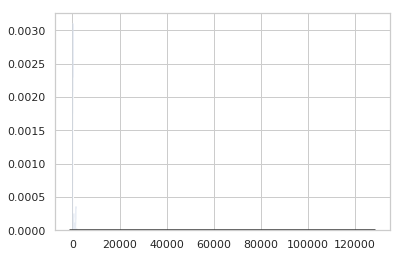

In [96]:
# api_len.sort()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats, integrate
# sns.set(style="whitegrid")
ax = sns.distplot(api_len,bins=2000,kde=False,fit=stats.gamma)
plt.show()

In [70]:
np.mean(api_len) , np.std(api_len) , np.percentile(api_len,50) , np.percentile(api_len,25) , np.percentile(api_len,75)

(564.9238405615442, 2239.6467360046886, 221.0, 83.0, 453.0)

In [105]:
np.max(api_len) , np.min(api_len) , np.percentile(api_len,84.6)

(127365, 1, 1010.0)

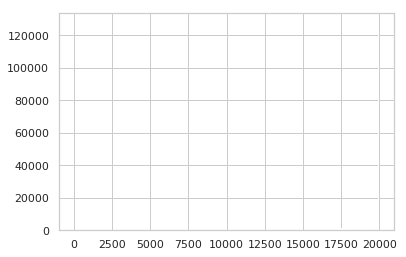

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
ys = api_len
xs = api_len_ind
width=0.1

fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
ax.bar(xs, ys, width,color='b', align='edge')
plt.savefig('output/netscore.png')

In [130]:
# Test

# print last hl3
print("=====")
print(hl3)

# get the api call sequence of last hk3
#print("=====")
#for time, api in hl3.li:
#    print(time, api)

# print each item

for i in hl3.li:
    print(i)

=====
class Hooklog3, ./data/aries_simplified/da974f5000a0af1023c5a0b4110dacf0f8d60ca60360cc0e93eb1d861b1fe8b1_3404.trace.hooklog, par = 0, len = 6, digit name = da974f-3404
('558550000', 'RegOpenKey')
('558750000', 'LoadLibrary')
('559730000', 'LoadLibrary')
('560390000', 'LoadLibrary')
('560390000', 'LoadLibrary')
('560620000', 'RegOpenKey')


In [19]:
# output
import pickle

out_hl_list = hl_list
out_tag = in_tag
with open(out_picklefile, 'wb') as o:
    pickle.dump(out_hl_list, o)

In [13]:
hl3

In [20]:
# output 2
with open(out_csvfile, 'wb') as o:
    o.write(b"hooklog\n")
    for h in hl_list:
        o.write(h.encode("ascii") + b"\n")

In [23]:
# output 3
total_api_set = set()
for file in hl_list:
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except UnicodeDecodeError:
        print(file)
    total_api_set.update(hl3.getWinSet(in_window))

with open(out_featuretabfile, 'wb') as o:
    o.write(b"hooklog")
    for api in total_api_set:
        o.write(b"\t" + api.encode("ascii"))
    o.write(b"\n")
    
    for h in hl_list:
        try:
            hl3 = Hooklog(h, in_parseFirstPar)
        except UnicodeDecodeError:
            print(h)
        hl3_set = hl3.getWinSet(in_window)
        o.write(hl3.digitname.encode("ascii"))
        for api in total_api_set:
            if api in hl3_set:
                o.write(b"\tTrue")
            else:
                o.write(b"\tFalse")
        o.write(b"\n")

./data/aries_simplified/01f6bc667f9cae673a84da14b295b7d3dc8d5c04588bc4c958b6a4d7c5a500af_3464.trace.hooklog
./data/aries_simplified/0f6e75fc69c51ba0ef5e5c9d36666b154099668ec9fd9b5f2dda9c059ca101b2_3172.trace.hooklog
./data/aries_simplified/0a010cca5da89ab16e4b5f626268997032c594fa231188ce48b6a546ad6e4f1c_3332.trace.hooklog
./data/aries_simplified/0b1adc128d743eb8d4d03c760fef768dc7b06a8e2c12e6166bccada73ab9913f_3288.trace.hooklog
./data/aries_simplified/0b1f4a70157a48e00d1739128a2dcb8d8e8f46e5c0e9b5ca0678e6bf24cbcce7_3292.trace.hooklog
./data/aries_simplified/887dbf8767d383a93a18ab6f6e42803bbf99c894cde35b64a6534d569e5c81eb_3296.trace.hooklog
./data/aries_simplified/0d0ed35f793afce19ffa101ad6912a441b82f8638571ce8ac96b14f6d8a60b29_3528.trace.hooklog
./data/aries_simplified/0cc68df0aef4db3c10b79aa5b98e0b1f35804b78ee9bcff08afe53d2ec76bf61_3420.trace.hooklog
./data/aries_simplified/0ee346769065d0de1985f0e6d7018f43e0f5fc8f8d578889a72e334e8bed50d6_3344.trace.hooklog
./data/aries_simplified/4abc

./data/aries_simplified/c6d288841b9719a01bd340da55538ce43aaa74265791a41ee493cabde9d2402e_2960.trace.hooklog
./data/aries_simplified/0d8c14c0986342b567a68bab41c93a27baa03d4a9baac9ef17264ffc947a6732_2960.trace.hooklog
./data/aries_simplified/0bb2f126798346d8661e5b8e1e452900947c17e7dede8dc410a37f8663898863_2940.trace.hooklog
./data/aries_simplified/0e7727730e917c9d4f691b12be62cef32613b5b727732d54a7747247d62f7803_3340.trace.hooklog
./data/aries_simplified/0eb635b092f2f29eed29508efdea15e937a711801504552101c61c5b9ea9918e_2824.trace.hooklog
./data/aries_simplified/0e9722c8c1c20179f1114e267c2ebb5ff80ab451a49603978d9a89f8db05708c_2904.trace.hooklog
./data/aries_simplified/0d6c63276b7a6d1929f9faa1ed35e9327b0f3957cd66d71111f9540186ee49c9_3200.trace.hooklog
./data/aries_simplified/0a878b44297513f8b5ae1f46e5d4da96ec24d8eddd5afff1cd8ccf2a232cbe97_3264.trace.hooklog


In [25]:
# output 4
# count api freq
freq_dict = dict()
exception_count = 0
for file in hl_list:
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except UnicodeDecodeError:
        print(file)
        exception_count+=1
    for i in hl3.li:
        if i[1] not in freq_dict:
            freq_dict[i[1]] = 1
        else:
            freq_dict[i[1]] += 1

print(freq_dict)
print(exception_count)
import pickle
with open(out_apifreq_pk, 'wb') as o:
    pickle.dump(freq_dict, o)

./data/aries_simplified/01f6bc667f9cae673a84da14b295b7d3dc8d5c04588bc4c958b6a4d7c5a500af_3464.trace.hooklog
./data/aries_simplified/0f6e75fc69c51ba0ef5e5c9d36666b154099668ec9fd9b5f2dda9c059ca101b2_3172.trace.hooklog
./data/aries_simplified/0a010cca5da89ab16e4b5f626268997032c594fa231188ce48b6a546ad6e4f1c_3332.trace.hooklog
./data/aries_simplified/0b1adc128d743eb8d4d03c760fef768dc7b06a8e2c12e6166bccada73ab9913f_3288.trace.hooklog
./data/aries_simplified/0b1f4a70157a48e00d1739128a2dcb8d8e8f46e5c0e9b5ca0678e6bf24cbcce7_3292.trace.hooklog
./data/aries_simplified/887dbf8767d383a93a18ab6f6e42803bbf99c894cde35b64a6534d569e5c81eb_3296.trace.hooklog
./data/aries_simplified/0d0ed35f793afce19ffa101ad6912a441b82f8638571ce8ac96b14f6d8a60b29_3528.trace.hooklog
./data/aries_simplified/0cc68df0aef4db3c10b79aa5b98e0b1f35804b78ee9bcff08afe53d2ec76bf61_3420.trace.hooklog
./data/aries_simplified/0ee346769065d0de1985f0e6d7018f43e0f5fc8f8d578889a72e334e8bed50d6_3344.trace.hooklog
./data/aries_simplified/4abc

In [43]:
import sklearn
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [118]:
api_list = list(freq_dict.keys())
api_list.extend(['<BOS>','<EOS>','<MOS>','<PAD>','<UNK>'])
api_list

['LoadLibrary',
 'RegOpenKey',
 'RegQueryValue',
 'RegCloseKey',
 'CreateFile',
 'CloseHandle',
 'RegOpenCurrentUser',
 'RegEnumValue',
 'RegCreateKey',
 'OpenProcess',
 'CreateRemoteThread',
 'CreateThread',
 'RegSetValue',
 'RegDeleteValue',
 'InternetOpen',
 'InternetConnect',
 'HttpSendRequest',
 'ExitProcess',
 'CreateProcess',
 'DeleteFile',
 'WinHttpOpen',
 'WinHttpConnect',
 'WinHttpOpenRequest',
 'WinHttpSendRequest',
 'WinHttpReadData',
 'CopyFile',
 'OpenThread',
 'RegDeleteKey',
 'TerminateProcess',
 'WinExec',
 'GetUrlCacheEntryInfo',
 'WinHttpWriteData',
 '<BOS>',
 '<EOS>',
 '<MOS>',
 '<PAD>',
 '<UNK>']

In [119]:
# len(freq_dict)

ser = pd.Series(api_list)
df = pd.DataFrame(ser)
df.columns = ['api']
df2 = pd.get_dummies(df['api'])
df2
# enc = OneHotEncoder()
# enc.fit(api_list)

,<BOS>,<EOS>,<MOS>,<PAD>,<UNK>,CloseHandle,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
pickle.dump(df2,open('./output/api_enc.pkl','wb'))

In [121]:
pickle.load(open('./output/api_enc.pkl','rb'))

,<BOS>,<EOS>,<MOS>,<PAD>,<UNK>,CloseHandle,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
df2['<EOS>'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

In [124]:
kk = df2.CreateFile.values
# kk = str(kk)
kk

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [91]:
np.array(list(v.values()),dtype='uint8')

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [99]:
dic2 = df2.to_dict()
for i,v in dic2.items():
#     print(type(v))
    v = np.array(list(v.values()),dtype='uint8')
#     print(v,kk)
    v = str(v)
    if v == kk:
        print(i)

CreateFile


In [53]:
df.join(df2)

,api,CloseHandle,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,CreateThread,DeleteFile,ExitProcess,GetUrlCacheEntryInfo,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,LoadLibrary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RegOpenKey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RegQueryValue,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,RegCloseKey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CreateFile,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,CloseHandle,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,RegOpenCurrentUser,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,RegEnumValue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,RegCreateKey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,OpenProcess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
